In [19]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import h5py
import pandas as pd
import deepdish as dd
import os
import numpy as np
import pylab as plt
from glob import glob
from tqdm import tqdm
import seaborn as sns
from scipy.stats import ncx2
from pesummary.gw.conversions.spins import spin_angles
from pesummary.utils.samples_dict import SamplesDict
import bilby
from GWFish.modules.detection import Network
from GWFish.modules.fishermatrix import compute_network_errors
import sys

## Get injection data SNRs

In [20]:
base_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
inj_data_file = os.path.join(base_dir, 'SNR_output_files_XPHM', 'BBH', 
                             'CE4020ET123_CoBA10_SNR_2_pop_PLP_spin_prec_z_MD_zmax_10_lmrd_22_365_days_corrected_td_SNR_data.h5')
#inj_data_file = os.path.join(base_dir, 'SNR_output_files_XPHM', 'BBH', 
#                             'LHI_SNR_1_pop_PLP_spin_prec_z_MD_zmax_6_lmrd_22_365_days_corrected_td_SNR_data.h5')

In [21]:
def decode_bytes_recursive(val):
    if isinstance(val, bytes):
        return val.decode('utf-8')
    elif isinstance(val, np.ndarray):
        if val.dtype.kind == 'S':  # Byte string array
            return np.vectorize(lambda x: x.decode('utf-8'))(val)
        elif val.dtype.kind in {'O'}:
            return np.vectorize(decode_bytes_recursive)(val)
        else:
            return val
    elif isinstance(val, list):
        return [decode_bytes_recursive(v) for v in val]
    elif isinstance(val, dict):
        return {k: decode_bytes_recursive(v) for k, v in val.items()}
    return val

def load_h5_group(group):
    data = {}
    for key in group.keys():
        item = group[key]
        if isinstance(item, h5py.Dataset):
            val = item[()]
            data[key] = decode_bytes_recursive(val)
        elif isinstance(item, h5py.Group):
            data[key] = load_h5_group(item)
    return data

In [22]:
# Main loader
inj_data = {}
with h5py.File(inj_data_file, 'r') as f:
    for key in f.keys():
        item = f[key]
        if isinstance(item, h5py.Dataset):
            val = item[()]
            inj_data[key] = decode_bytes_recursive(val)
        elif isinstance(item, h5py.Group):
            inj_data[key] = load_h5_group(item)

In [23]:
pd.DataFrame(inj_data['results'])

,PSD_C1,PSD_CE20,PSD_E1,PSD_E2,PSD_E3,SNR_C1,SNR_CE20,SNR_E1,SNR_E2,SNR_E3,...,spin2x,spin2y,spin2z,srcmass1,srcmass2,srcmchirp,srcmtotal,theta_jn,time_interval,trigger_time
0,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,31.175632,12.726711,3.973213,6.571543,5.159677,...,0.239489,-0.854048,0.397808,6.675367,6.487496,5.728769,13.162863,1.405201,415.946042,1.893024e+09
1,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,37.973391,18.606019,18.344760,17.589404,17.019558,...,-0.110467,0.069273,0.018477,8.189928,4.554110,5.271677,12.744038,2.733539,216.014409,1.893025e+09
2,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,20.989421,11.322291,13.647052,14.217145,13.416048,...,-0.003122,-0.017818,-0.005669,10.569285,9.315992,8.634924,19.885277,2.276711,138.279527,1.893025e+09
3,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,15.380034,5.591841,3.353253,4.325967,2.374076,...,-0.017713,0.024490,-0.093127,7.643692,3.954608,4.735492,11.598300,0.715030,255.327947,1.893025e+09
4,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,14.132469,7.187924,30.631974,17.091912,33.310609,...,0.224326,0.076467,-0.586815,32.661259,31.489093,27.917469,64.150352,1.629448,1861.574855,1.893027e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31723,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,14.094867,8.230703,1.831830,0.150492,1.809944,...,0.031301,-0.007168,0.126385,8.118676,7.077545,6.595893,15.196221,1.406815,456.839222,1.924702e+09
31724,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,51.886866,11.077134,22.853409,20.335362,14.760035,...,0.003559,0.057013,-0.031519,9.865644,6.252576,6.802166,16.118219,0.357377,2398.698252,1.924704e+09
31725,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,87.690403,70.502659,13.607195,29.382571,22.157020,...,-0.321144,0.208551,-0.037655,27.424645,21.917513,21.316492,49.342158,2.231795,1968.124680,1.924706e+09
31726,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,42.121155,30.781091,17.689332,18.346002,18.826865,...,0.015982,0.289463,-0.924451,11.347814,9.822560,9.186211,21.170374,2.466810,2113.399173,1.924708e+09


### Get detected

In [24]:
def get_detected_SNRs(data_dict, ifo_threshold=5, network_threshold=12, 
                      method='network', return_detected_dict=False, 
                      snr_type='mf_from_opt'):
    if type(data_dict) == pd.core.frame.DataFrame:
        pass
    else:
        data_dict = pd.DataFrame(data_dict)
        
    if snr_type == 'opt':
        SNR_keys = [key for key in data_dict.keys() if 'SNR' in key and 'mf' not in key]
    elif snr_type == 'mf_from_opt':
        SNR_keys = [key for key in data_dict.keys() if 'SNR_mf_from_opt' in key]
    elif snr_type == 'mf':
        SNR_keys = [key for key in data_dict.keys() if 'SNR_mf' in key and 'from_opt' not in key]
    else:
        raise KeyError('Please choose snr_type from "opt" or "mf"')
    print(SNR_keys)
    detected_bool_dict = {}
    detected_dict = {}
    
    for key in SNR_keys:
        if snr_type == 'opt':
            dict_key = key.split('SNR_')[-1]
        elif snr_type == 'mf_from_opt':
            dict_key = key.split('SNR_mf_from_opt_')[-1]
        elif snr_type == 'mf':
            dict_key = key.split('SNR_mf_')[-1]
        
        if "network" in key:
            threshold = network_threshold
        else:
            threshold = ifo_threshold

        detected_bool_dict[dict_key] = data_dict[key] >= threshold
        detected_dict[dict_key] = data_dict[detected_bool_dict[dict_key]]

    if method=='all':
        detected_events_df = data_dict[np.all(tuple(detected_bool_dict.values()), axis=0) & detected_bool_dict['network']]
    elif method == 'two-detector':
        detector_keys = [key for key in detected_bool_dict.keys() if key != 'network']
        detection_sum = np.sum([detected_bool_dict[key] for key in detector_keys], axis=0)
        detected_events_df = data_dict[(detection_sum >= 2) & (detected_bool_dict['network'])]
    elif method=='network':
        detected_events_df = detected_dict['network']

    if return_detected_dict:
        return(detected_events_df, detected_dict)
    else:
        return(detected_events_df)

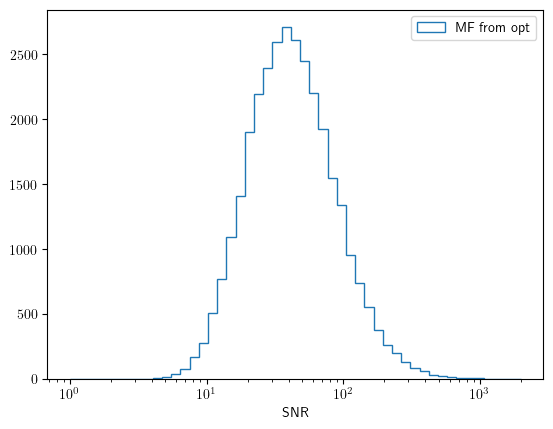

In [25]:
plt.hist(inj_data['results']['SNR_mf_from_opt_network'], bins=np.logspace(0,3.3,50), histtype=u'step', label='MF from opt');
plt.xlabel('SNR')
plt.legend()
plt.xscale('log')

In [26]:
inj_data['detected_mf_from_opt'] = get_detected_SNRs(inj_data['results'], method='two-detector', 
                                                     snr_type='mf_from_opt', network_threshold=100)

['SNR_mf_from_opt_C1', 'SNR_mf_from_opt_CE20', 'SNR_mf_from_opt_E1', 'SNR_mf_from_opt_E2', 'SNR_mf_from_opt_E3', 'SNR_mf_from_opt_network']


### Detected percentage

In [27]:
n_total = len(inj_data['results']['redshift'])
n_detected = len(inj_data['detected_mf_from_opt']['redshift'])

print('Total =', n_total)
print('detected =', n_detected, '=', round(n_detected*100/n_total, 3), '%')

Total = 31728
detected = 3873 = 12.207 %


### Choose n_events from detected as injection parameters

In [10]:
n_events = len(inj_data['detected_mf_from_opt']['redshift'])
inj_data['selected_n_events'] = inj_data['detected_mf_from_opt'].iloc[:n_events].reset_index(drop=True)
inj_data['selected_n_events'].insert(5, 'SNR_ET', np.sqrt(inj_data['selected_n_events']['SNR_E1']**2 + inj_data['selected_n_events']['SNR_E2']**2 + inj_data['selected_n_events']['SNR_E3']**2))

In [11]:
len(inj_data['selected_n_events']['redshift'])

16

In [12]:
inj_data['selected_n_events']

,PSD_C1,PSD_CE20,PSD_E1,PSD_E2,PSD_E3,SNR_ET,SNR_C1,SNR_CE20,SNR_E1,SNR_E2,...,spin2x,spin2y,spin2z,srcmass1,srcmass2,srcmchirp,srcmtotal,theta_jn,time_interval,trigger_time
0,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,417.781634,1125.229598,740.785889,271.634410,238.710086,...,-0.081011,0.279980,-0.103331,84.864181,46.640465,54.288040,131.504647,2.502697,2866.907215,1.898516e+09
1,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,443.981657,741.266151,437.114293,247.334582,269.892772,...,-0.129552,0.352160,0.197805,30.230211,26.135854,24.457000,56.366065,2.193822,2553.102731,1.898884e+09
2,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,299.963344,724.424731,520.997514,169.536051,202.182113,...,-0.084985,0.011781,-0.026057,27.401687,22.043301,21.370167,49.444988,0.679954,509.058845,1.899137e+09
3,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,381.343269,1467.252880,781.853650,276.162049,149.544720,...,0.292830,0.015807,-0.076006,56.294480,40.054448,41.219295,96.348928,2.308180,1304.952157,1.899476e+09
4,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,350.715731,1261.300574,737.430547,262.870615,178.854200,...,-0.311960,-0.354677,-0.166627,34.272723,32.494332,29.049676,66.767055,0.619327,184.737440,1.899598e+09
5,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,852.553961,1223.176976,851.221459,498.581061,482.251904,...,0.460335,-0.098760,0.348517,7.369737,7.127275,6.309132,14.497012,0.609669,580.171655,1.900585e+09
6,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,448.138166,673.559724,501.961148,245.825976,272.021640,...,0.344667,0.250656,0.204141,40.192234,34.213269,32.261237,74.405503,0.451065,453.125314,1.901824e+09
7,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,155.227591,910.638685,502.487958,109.616341,61.233108,...,0.786217,0.550267,0.150023,19.735829,19.302918,16.991348,39.038747,1.382490,791.163647,1.905506e+09
8,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,743.074315,991.496464,589.998361,461.944261,251.663772,...,0.010702,-0.037015,-0.006078,10.161459,7.413866,7.537370,17.575326,1.662105,499.976940,1.906868e+09
9,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,211.265202,755.939137,489.279902,153.678031,124.975347,...,0.502620,-0.146433,0.145463,37.765263,32.139827,30.309577,69.905091,0.342944,325.848169,1.908110e+09


## Bilby

In [286]:
import bilby
bilby.core.utils.log.setup_logger(log_level="warning")

In [287]:
f_low = inj_data['selected_n_events']['f_lower'][0]
f_ref = inj_data['selected_n_events']['f_ref'][0]

In [288]:
def calc_bilby_snr(injection_parameters):
    waveform_arguments = dict(
        waveform_approximant="IMRPhenomXPHM",
        reference_frequency=f_ref,
        minimum_frequency=f_low,
    )
    
    # Create the waveform_generator using a LAL BinaryBlackHole source function
    duration = 500
    waveform_generator = bilby.gw.WaveformGenerator(
        duration=duration,
        sampling_frequency=4096,
        frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
        parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
        waveform_arguments=waveform_arguments,
    )
    
    ifos = bilby.gw.detector.InterferometerList(["L1", "H1", "A1"])
    ifos = bilby.gw.detector.InterferometerList(['CE', 'ET'])
    ifos.set_strain_data_from_zero_noise(
        sampling_frequency=4096,
        duration=duration,
        start_time=injection_parameters["geocent_time"] - duration +2,
    )

    psd_files = ['../noise_curves/CE40-psd.txt', '../noise_curves/ET10_CoBA-psd.txt']
    for ifo, psd_file in zip(ifos, psd_files):
        #ifo.power_spectral_density = bilby.gw.detector.psd.PowerSpectralDensity(psd_file='../noise_curves/Asharp-psd.txt')
        ifo.power_spectral_density = bilby.gw.detector.psd.PowerSpectralDensity(psd_file=psd_file)
        ifo.minimum_frequency = f_low
    
    ifos.inject_signal(
        waveform_generator=waveform_generator, parameters=injection_parameters
    )

    snrdict_return = {}
    optsnrsquared = 0
    for ifo in ifos:
        det = ifo.name
        SNR = ifos.meta_data[det]["optimal_SNR"]
        snrdict_return[f'SNR_{det}'] = SNR
        optsnrsquared += SNR ** 2
    snrdict_return['SNR_network'] = np.sqrt(optsnrsquared)

    return snrdict_return

In [289]:
pycbc_to_bilby_map = {
    'mass1':'mass_1',
    'mass2':'mass_2',
    'distance':'luminosity_distance',
    'theta_jn':'theta_jn',
    'trigger_time':'geocent_time',
    'coa_phase':'phase',
    'ra':'ra',
    'dec':'dec',
    'polarization':'psi',
    'spin1_a': 'a_1',
    'spin2_a': 'a_2',
    'spin1_polar': 'tilt_1',
    'spin2_polar':'tilt_2',
    'phi_12': 'phi_12',
    'phi_jl': 'phi_jl'
}

In [293]:
bilby_snr = []
for event in range(len(inj_data['selected_n_events']['distance'])):
    bilby_params = {pycbc_to_bilby_map[key]:inj_data['selected_n_events'][key][event] for key in pycbc_to_bilby_map.keys()}
    snr_dict = calc_bilby_snr(bilby_params)
    snr_dict.update(bilby_params)
    bilby_snr.append(snr_dict)

In [296]:
bilby_snr = pd.DataFrame(bilby_snr).rename(columns={'SNR_A1':'SNR_I1', 
                                                    'SNR_CE':'SNR_C1', 
                                                    'SNR_ET1':'SNR_E1',
                                                    'SNR_ET2':'SNR_E2', 
                                                    'SNR_ET3':'SNR_E3'})
bilby_snr

,SNR_C1,SNR_E1,SNR_E2,SNR_E3,SNR_network,mass_1,mass_2,luminosity_distance,theta_jn,geocent_time,phase,ra,dec,psi,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl
0,1127.346922,271.618566,181.399276,207.233729,1191.863769,112.098681,61.608261,1731.001244,2.502697,1.898516e+09,0.049486,5.032525,0.652315,0.358538,0.625175,0.309239,2.115097,1.911496,0.542926,4.630513
1,838.349049,247.309959,215.786337,231.326326,929.552019,35.579054,30.760254,882.761439,2.193822,1.898884e+09,5.776514,0.609846,1.296106,1.987036,0.506002,0.424179,2.598843,1.085664,0.714457,4.251394
2,663.439354,169.517386,123.995772,176.585567,717.945217,33.512777,26.959370,1142.685938,0.679954,1.899137e+09,4.314234,3.325828,-0.387247,0.533400,0.697060,0.089667,0.653937,1.865643,3.332051,0.873466
3,1346.771977,276.137687,189.536940,130.361033,1393.902806,67.486282,48.017600,1004.700098,2.308180,1.899476e+09,6.226073,2.024654,-0.312625,1.972226,0.441145,0.302946,1.020867,1.824394,3.824996,5.217051
4,1144.637888,262.825431,128.539050,154.736439,1191.527908,41.132143,38.997820,1012.222100,0.619327,1.899598e+09,5.255678,4.809184,-0.215325,0.917272,0.212716,0.500878,0.636756,1.909929,2.230564,5.907256
5,1462.388342,498.763469,426.296228,415.106254,1655.713241,7.701266,7.447897,205.856686,0.609669,1.900585e+09,0.530393,2.369114,-0.970579,2.815375,0.738307,0.585770,2.253311,0.933564,4.663188,4.375148
6,579.130622,245.817139,223.215220,236.339056,708.166313,52.618630,44.791124,1657.971327,0.451065,1.901824e+09,0.477836,4.835295,-0.408574,0.419090,0.425918,0.472543,0.897280,1.124082,3.492746,5.894837
7,552.896373,109.613940,78.643888,52.814046,571.562595,22.092270,21.607671,574.804139,1.382490,1.905506e+09,3.260259,2.050192,-0.780764,1.602098,0.630524,0.971308,1.285583,1.415721,1.836323,0.100216
8,665.822167,461.965878,452.310428,224.509634,954.840788,10.430791,7.610373,119.668025,1.662105,1.906868e+09,2.932253,2.464894,-0.104937,0.745376,0.815941,0.039007,1.453523,1.727256,1.576356,3.245061
9,720.833441,153.655802,63.166576,108.079355,747.584189,52.809942,44.943481,2228.180279,0.342944,1.908110e+09,0.197642,3.853865,-0.475035,2.595572,0.036763,0.543349,1.361044,1.299776,1.946978,2.747124


## PyCBC

In [233]:
from pycbc.waveform import get_fd_waveform
from pycbc.detector import Detector
from pycbc.filter.matchedfilter import sigmasq
import pycbc

In [234]:
def calc_PyCBC_snr(**params_dict):
    hp, hc = get_fd_waveform(**params_dict)
    dets = ['L1', 'H1', 'I1']
    hf = {}
    snrs = {}
    snr_sq_netw = 0
    for det in dets:
        fp, fc = Detector(det).antenna_pattern(params_dict['ra'], params_dict['dec'], params_dict['polarization'], params_dict['trigger_time'])
        hf[det] = hp*fp + hc*fc
        psd = pycbc.psd.read.from_txt('../noise_curves/Asharp-asd.txt', len(hf[det]), hf[det].delta_f, 10)
        snr_sq = sigmasq(hf[det], psd=psd, low_frequency_cutoff=10)
        snrs[f'SNR_{det}'] = np.sqrt(snr_sq)
        snr_sq_netw += snr_sq
    snrs['SNR_network'] = np.sqrt(snr_sq_netw)
    return(snrs)

In [235]:
samples = SamplesDict(bilby_snr.to_dict(orient='list'))
samples.generate_all_posterior_samples(f_low=f_low, f_ref=f_ref, delta_f=inj_data['selected_n_events']['delta_f'][0], 
                                       f_start=f_low)
samples = pd.DataFrame(samples)

2025-08-30  13:06:25 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2025-08-30  13:06:25 PESummary WARNING : The redshift is being approximated using interpolation. Bear in mind that this does introduce a small error.
2025-08-30  13:06:25 PESummary INFO    : Averaging the final spin from the following fits: function bbh_final_spin_precessing_projected_UIB2016 at 0x7f6d81af0680, function bbh_final_spin_precessing_projected_Healyetal at 0x7f6d81af04a0, function bbh_final_spin_precessing_HBR2016 at 0x7f6d81af0860
2025-08-30  13:06:25 PESummary INFO    : Averaging the peak luminosity from the following fits: function bbh_peak_luminosity_non_precessing_UIB2016 at 0x7f6d81af0900, function bbh_peak_luminosity_non_precessing_Healyetal at 0x7f6d81af09a0
2025-08-30  13:06:25 PESummary INFO    : Averaging the final mass from the following fits: function bbh_final_mass_non_precessing_UIB2016 at 0x7f6d81a7fce0, functi

In [236]:
PyCBC_wf_gen_keys_map = {
    'mass_1':'mass1', 
    'mass_2':'mass2', 
    'luminosity_distance':'distance',
    'iota':'inclination',
    'geocent_time':'trigger_time',
    'phase':'coa_phase',
    'ra':'ra',
    'dec':'dec',
    'psi':'polarization',
    'spin_1x':'spin1x',
    'spin_1y':'spin1y',
    'spin_1z':'spin1z',
    'spin_2x':'spin2x',
    'spin_2y':'spin2y',
    'spin_2z':'spin2z'
}

In [237]:
pycbc_samples = samples.rename(columns=PyCBC_wf_gen_keys_map)
pycbc_samples[PyCBC_wf_gen_keys_map.values()]

,mass1,mass2,distance,inclination,trigger_time,coa_phase,ra,dec,polarization,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z
0,62.449058,47.077733,2551.448280,2.607957,1.896012e+09,0.743181,4.322145,0.883840,2.974579,-0.016413,-0.079621,0.089671,0.204441,-0.248578,0.189613
1,40.438088,35.585244,1752.897675,0.533236,1.896733e+09,1.987800,3.783244,-0.276989,2.350833,0.536211,-0.111716,0.225021,-0.001927,0.004706,0.001575
2,101.074872,92.346816,1338.594547,2.088311,1.898149e+09,2.925349,3.911826,-0.785394,2.725428,0.120226,-0.161576,-0.324434,0.236339,-0.137914,-0.501259
3,42.212902,36.582607,1408.229600,1.149886,1.902833e+09,1.289168,4.895159,1.018387,1.080128,0.174065,0.139973,0.077053,0.045662,0.518583,0.740123
4,35.589119,32.929047,1049.640856,2.609916,1.903170e+09,2.733542,1.718538,-1.135541,1.296712,-0.209487,0.267998,-0.188737,-0.233910,0.610934,0.030314
5,37.518773,27.396356,627.189776,1.177254,1.904770e+09,6.279988,1.294620,0.052230,1.204652,0.054100,-0.006736,-0.084078,-0.374489,-0.279908,-0.465468
6,43.653374,41.768176,2034.160446,2.921780,1.905429e+09,5.843279,0.558239,1.173160,2.632715,-0.070993,0.302761,0.349354,0.505143,0.071592,-0.089922
7,42.363974,37.236274,229.644301,1.755495,1.911749e+09,4.380052,3.693147,-0.543764,1.406096,-0.513832,-0.048789,0.582170,-0.533275,-0.338310,-0.114139
8,35.353324,33.905179,703.054933,1.928437,1.911845e+09,1.773192,4.071022,0.697420,0.508098,-0.607697,0.229323,-0.121928,0.103031,0.293034,0.824697
9,42.104959,38.718185,1217.401836,2.921304,1.915450e+09,2.087846,1.191531,0.475548,2.843273,0.048854,0.196268,-0.100129,-0.035329,-0.167992,0.096600


In [238]:
pycbc_snrs = []
for i in tqdm(range(len(inj_data['selected_n_events']))):
    pycbc_snrs.append(calc_PyCBC_snr(**inj_data['selected_n_events'][i:i+1].T.to_dict()[i]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.48it/s]


In [239]:
pycbc_snrs_df = pd.DataFrame(pycbc_snrs)
pycbc_snrs_df

,SNR_L1,SNR_H1,SNR_I1,SNR_network
0,67.340425,68.749780,33.029451,101.745809
1,81.206350,60.974486,65.264448,120.713742
2,53.340755,53.243821,76.792150,107.597282
3,63.372192,74.956167,14.322063,99.194674
4,98.431276,107.935736,42.543495,152.147259
5,70.533330,63.756349,60.876777,112.897319
6,64.530668,69.414135,39.185623,102.557507
7,88.022806,228.573584,160.132280,292.636711
8,81.305998,71.565714,37.405785,114.592799
9,112.225665,123.978328,81.453833,186.010625


In [240]:
pycbc_snrs_from_converted = []
for i in tqdm(range(len(inj_data['selected_n_events']))):
    pycbc_snrs_from_converted.append(calc_PyCBC_snr(**pycbc_samples[i:i+1].T.to_dict()[i], 
                                                    approximant=inj_data['selected_n_events']['approximant'][0], 
                                                    f_lower=inj_data['selected_n_events']['f_lower'][0],
                                                    f_ref=inj_data['selected_n_events']['f_ref'][0],
                                                    f_final=inj_data['selected_n_events']['f_final'][0], 
                                                    delta_f=inj_data['selected_n_events']['delta_f'][0])
                                    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.42it/s]


In [241]:
pycbc_snrs_from_converted_df = pd.DataFrame(pycbc_snrs_from_converted)
pycbc_snrs_from_converted_df

,SNR_L1,SNR_H1,SNR_I1,SNR_network
0,67.340425,68.749780,33.029451,101.745809
1,81.206350,60.974486,65.264448,120.713742
2,53.340755,53.243821,76.792150,107.597282
3,63.372192,74.956167,14.322063,99.194674
4,98.431276,107.935736,42.543495,152.147259
5,70.533330,63.756349,60.876777,112.897319
6,64.530668,69.414135,39.185623,102.557507
7,88.022806,228.573584,160.132280,292.636711
8,81.305998,71.565714,37.405785,114.592799
9,112.225665,123.978328,81.453833,186.010625


## Comparison plots

Text(0.5, 1.0, 'SNR network')

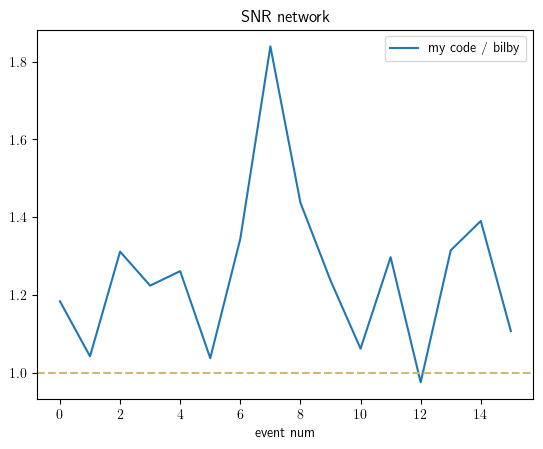

In [297]:
plt.plot(inj_data['selected_n_events']['SNR_network']/bilby_snr['SNR_network'], label='my code / bilby')
#plt.plot(inj_data['selected_n_events']['SNR_network']/gwfish_snr['SNR_network'].values, label='my code / GWFish')
#plt.plot(gwfish_snr['SNR_network'].values/bilby_snr['SNR_network'], label='GWFish / bilby')
#plt.plot(inj_data['selected_n_events']['SNR_network']/pycbc_snrs_from_converted_df['SNR_network'].values, label='my code / PyCBC')
plt.axhline(1, c='y', ls='--')
plt.legend()
plt.xlabel('event num')
plt.title('SNR network')

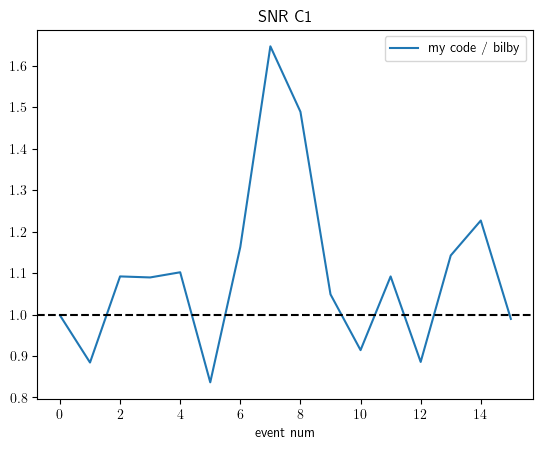

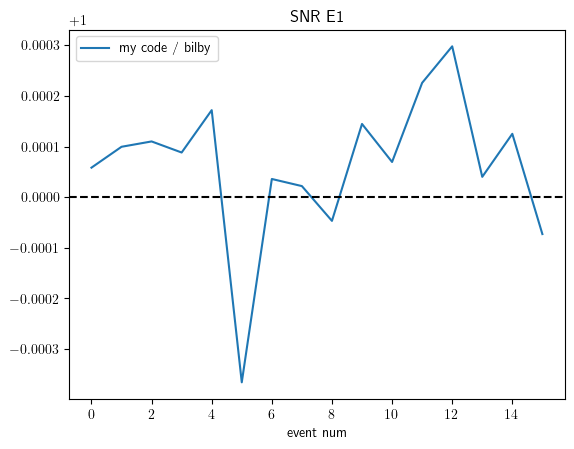

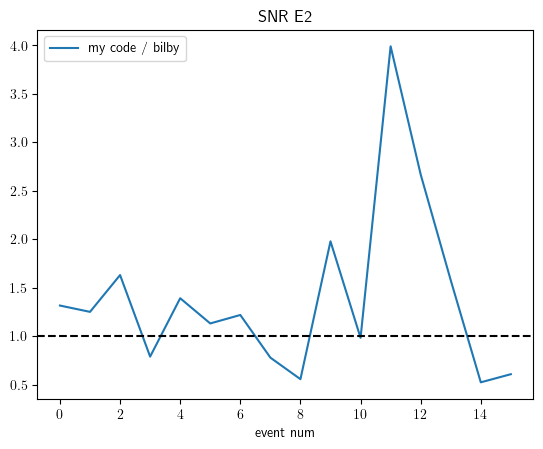

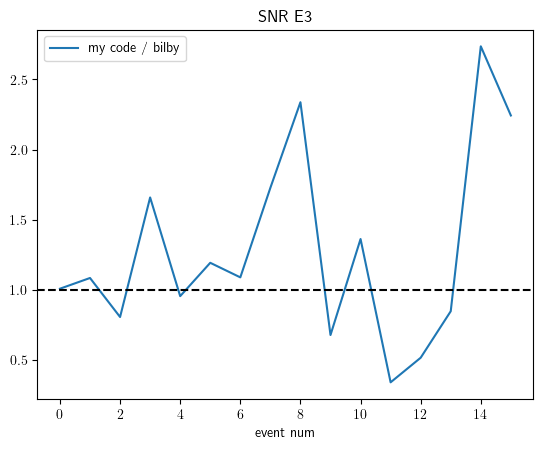

In [300]:
#for det in ['L1', 'H1', 'I1']:
for det in ['C1', 'E1', 'E2', 'E3']:
    plt.figure()
    #plt.plot(pycbc_snrs_from_converted_df[f'SNR_{det}']/bilby_snr[f'SNR_{det}'], label='pycbc / bilby')
    plt.plot(inj_data['selected_n_events'][f'SNR_{det}']/bilby_snr[f'SNR_{det}'].values, label='my code / bilby')
    #plt.plot(gwfish_snr[f'SNR_{det}'].values/bilby_snr[f'SNR_{det}'], label='GWFish / bilby')
    plt.axhline(1, c='k', ls='--')
    plt.legend()
    plt.xlabel('event num')
    plt.title(f'SNR {det}')

## GWBench

In [13]:
fm_params_str = 'Mc eta DL iota tc phic ra dec psi'
def run_analysis(inj_params, logging_level='WARNING', num_cores=2):
    f"""
    Parameters:
    -------------------------------------------------------------
    inj_params: dict
        dict with keys: Mc, eta, tc, phic, 
                        DL, iota, ra, dec, psi, 
                        chi1x, chi1y, chi1z, chi2x, chi2y, chi2z
    Returns:
    -----------------------
    FM: matrix
        Fisher matrix with parameter order as: {fm_params_str}
    cov: matrix
        Covariance matrix corresponding to the FM
    errors: dict
        Parameter errors
    """
    wf_model_name = 'lal_bbh'
    wf_other_var_dic = {'approximant':'IMRPhenomXPHM'}
    user_psds = {'A-Sharp':{'psd_file': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/scripts/next_gen_detect/noise_curves/Asharp-asd.txt', 
                            'is_asd': True},
                 'CE40':{'psd_file': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/scripts/next_gen_detect/noise_curves/CE40-asd.txt', 
                         'is_asd': True}, 
                 'CE20':{'psd_file': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/scripts/next_gen_detect/noise_curves/CE20-asd.txt', 
                         'is_asd': True}, 
                 'ET10-CoBA':{'psd_file': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/scripts/next_gen_detect/noise_curves/18213_ET10kmcolumns.txt', 
                              'is_asd': False}}
    user_locs = {'C1':{'longitude': -2.06175744538, 'latitude': 0.59637900541, 'arm_azimuth':0, 'which_arm':'y', 'shape':'L'}}
    conv_log = ('Mc', 'DL')
    ana_deriv_symbs_string = 'DL tc phic ra dec psi'
    network_spec = ['CE40_C1', 'CE20_CEB', 'ET10-CoBA_ET1', 'ET10-CoBA_ET2', 'ET10-CoBA_ET3']
    f_low = 5
    f_high = 1024
    df = 1/16
    f_arr = np.arange(f_low, f_high+df, df)
    net = Network(network_spec, logger_level=logging_level)
    net.set_net_vars(wf_model_name=wf_model_name, 
                     wf_other_var_dic=wf_other_var_dic,
                     f=f_arr, 
                     inj_params=inj_params,
                     deriv_symbs_string=fm_params_str,
                     ana_deriv_symbs_string=ana_deriv_symbs_string,
                     conv_log=conv_log, 
                     user_psds=user_psds,
                     user_locs=user_locs)
    net.calc_errors(derivs='num', f_lo=f_low, f_hi=f_high, num_cores=num_cores)
    return(net)

In [34]:
from pycbc.detector import Detector
d1 = Detector('C1')
d2 = Detector('V1')
print(d1.gmst_estimate(1234), d2.gmst_estimate(1234))

1.9168559938653758 1.9168559938653758


## GWFish

In [13]:
pycbc_to_pesummary_map = {
    'mchirp': 'chirp_mass',
    'q': 'mass_ratio',
    'distance': 'luminosity_distance',
    'theta_jn': 'theta_jn',
    'ra': 'ra',
    'dec': 'dec',
    'polarization': 'psi',
    'trigger_time': 'geocent_time',
    'coa_phase': 'phase',
    'spin1_a': 'a_1',
    'spin2_a': 'a_2',
    'spin1_polar': 'tilt_1',
    'spin2_polar':'tilt_2',
    'phi_12': 'phi_12',
    'phi_jl': 'phi_jl',
    'mass1': 'mass_1',
    'mass2': 'mass_2'
}
gwfish_det_dict = {'L1':'L', 'H1':'H', 'I1':'IN'}

In [14]:
gwfish_input_data = {pycbc_to_pesummary_map[key]:inj_data['selected_n_events'][key] for key in pycbc_to_pesummary_map.keys() if key != 'q'}
gwfish_input_data = pd.DataFrame(gwfish_input_data)
gwfish_input_data['mass_ratio'] = 1/inj_data['selected_n_events']['q']

In [15]:
gwfish_input_data

,chirp_mass,luminosity_distance,theta_jn,ra,dec,psi,geocent_time,phase,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,mass_1,mass_2,mass_ratio
0,71.710085,1731.001244,2.502697,5.032525,0.652315,0.358538,1.898516e+09,0.049486,0.625175,0.309239,2.115097,1.911496,0.542926,4.630513,112.098681,61.608261,0.549590
1,28.784349,882.761439,2.193822,0.609846,1.296106,1.987036,1.898884e+09,5.776514,0.506002,0.424179,2.598843,1.085664,0.714457,4.251394,35.579054,30.760254,0.864561
2,26.136114,1142.685938,0.679954,3.325828,-0.387247,0.533400,1.899137e+09,4.314234,0.697060,0.089667,0.653937,1.865643,3.332051,0.873466,33.512777,26.959370,0.804451
3,49.414028,1004.700098,2.308180,2.024654,-0.312625,1.972226,1.899476e+09,6.226073,0.441145,0.302946,1.020867,1.824394,3.824996,5.217051,67.486282,48.017600,0.711516
4,34.863743,1012.222100,0.619327,4.809184,-0.215325,0.917272,1.899598e+09,5.255678,0.212716,0.500878,0.636756,1.909929,2.230564,5.907256,41.132143,38.997820,0.948111
5,6.592950,205.856686,0.609669,2.369114,-0.970579,2.815375,1.900585e+09,0.530393,0.738307,0.585770,2.253311,0.933564,4.663188,4.375148,7.701266,7.447897,0.967100
6,42.235575,1657.971327,0.451065,4.835295,-0.408574,0.419090,1.901824e+09,0.477836,0.425918,0.472543,0.897280,1.124082,3.492746,5.894837,52.618630,44.791124,0.851241
7,19.020100,574.804139,1.382490,2.050192,-0.780764,1.602098,1.905506e+09,3.260259,0.630524,0.971308,1.285583,1.415721,1.836323,0.100216,22.092270,21.607671,0.978065
8,7.737150,119.668025,1.662105,2.464894,-0.104937,0.745376,1.906868e+09,2.932253,0.815941,0.039007,1.453523,1.727256,1.576356,3.245061,10.430791,7.610373,0.729606
9,42.384107,2228.180279,0.342944,3.853865,-0.475035,2.595572,1.908110e+09,0.197642,0.036763,0.543349,1.361044,1.299776,1.946978,2.747124,52.809942,44.943481,0.851042


In [16]:
import GWFish.modules as gwf_mods
import pathlib
#detectors = ['A_sharp_L', 'A_sharp_H', 'A_sharp_IN']
detectors = ['CE1', 'CE2', 'ET']
network = gwf_mods.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.), config=pathlib.Path('detectors.yaml'))
gwfish_snr = gwf_mods.utilities.get_snr(gwfish_input_data, network, 
                                        'IMRPhenomXPHM', 
                                        f_ref=inj_data['selected_n_events']['f_ref'][0])

In [17]:
gwfish_snr.rename(columns={f'A_sharp_{val}':f'SNR_{key}' for key, val in gwfish_det_dict.items()}, inplace=True)
gwfish_snr.rename(columns={'CE1':'SNR_C1', 'CE2':'SNR_CE20', 'ET':'SNR_ET'}, inplace=True)
gwfish_snr.rename(columns={'network':'SNR_network'}, inplace=True)
gwfish_snr

,SNR_C1,SNR_CE20,SNR_ET,SNR_network
event_0,1125.090675,740.680304,417.512297,1410.231491
event_1,741.221444,437.095154,443.626007,968.124701
event_2,724.397655,520.998010,299.837638,941.325394
event_3,1467.229724,781.881299,381.787657,1705.832126
event_4,1261.281898,737.444287,351.070660,1502.633259
event_5,1222.432721,851.178340,853.062264,1716.555141
event_6,673.507502,501.922744,447.949704,951.944186
event_7,910.585130,502.468711,155.204758,1051.536306
event_8,991.264353,589.564304,742.669108,1371.768381
event_9,755.923105,489.282017,211.192192,924.888520


Text(0.5, 1.0, 'my code / GWFish')

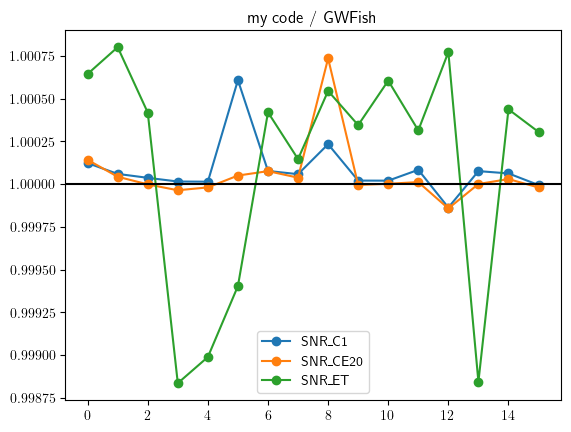

In [18]:
for key in gwfish_snr.keys():
    if 'network' in key:
        continue
    my_snr = inj_data['selected_n_events'][key]
    gwfish_snr_det = gwfish_snr[key].values
    plt.plot(my_snr/gwfish_snr_det, 'o-', label=key)
plt.legend()
plt.axhline(1, c='k')
plt.title('my code / GWFish')